## Spotify Web API Authentication 

In [1]:
import requests
import base64

# Replace with your own Client ID and Client Secret
CLIENT_ID = '80d535f7b69f42488bd8c4f61f60a5bf'
CLIENT_SECRET = '5a3cec53ca4643e586d97779df8bd45b'

# Base64 encode the client ID and client secret
client_credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_credentials_base64 = base64.b64encode(client_credentials.encode())

# Request the access token
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully.")
else:
    print("Error obtaining access token.")
    exit()

Access token obtained successfully.


In [2]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

def get_trending_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the access token
    sp = spotipy.Spotify(auth=access_token)

    # Get the tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')

    # Extract relevant information and store in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = sp.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = sp.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

        # Add additional track information to the track data
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)

    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(music_data)

    return df

## Playlist Selection

In [4]:

# Gospel Hits 2024
playlist_id = '2AZl8RqhvnaMbG5gEEO72q' 

# Call the function to get the music data from the playlist and store it in a DataFrame
music_df = get_trending_playlist_data(playlist_id, access_token)

# Display the DataFrame
print(music_df)

          Track Name                                            Artists  \
0         E Dey Flow  Moses Bliss, Neeja, Ajay Asika, Festizie, S.O....   
1      Omemma - Live                                     Chandler Moore   
2             Friend                                  Olabayo, MC Jamil   
3    You Do This One                                       Mercy Chinwo   
4                Ose                                         Mike Aremu   
..               ...                                                ...   
95        Confidence                                       Mercy Chinwo   
96        Tobechukwu                     Nathaniel Bassey, Mercy Chinwo   
97       Love Theory                                      Kirk Franklin   
98          Blessing                                        Snow Prince   
99  All That Matters                                       Minister GUC   

                             Album Name                Album ID  \
0                            E D

## Data Cleaning and Preparation

In [5]:
print(music_df.isnull().sum())

Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

data = music_df

## Popularity Based Filtering

In [7]:
# Function to calculate weighted popularity scores based on release date
def calculate_weighted_popularity(release_date):
    # Convert the release date to datetime object
    if pd.isnull(release_date) or release_date == '':
        return 0
    
    release_date = datetime.strptime(release_date, '%Y-%m-%d')
    # Calculate the time span between release date and today's date
    time_span = datetime.now() - release_date

    # Calculate the weighted popularity score based on time span (e.g., more recent releases have higher weight)
    weight = 1 / (time_span.days + 1)
    return weight

In [8]:
# Normalize the music features using Min-Max scaling
scaler = MinMaxScaler()
music_features = music_df[['Danceability', 'Energy', 'Key',
                           'Loudness', 'Mode', 'Speechiness', 'Acousticness',
                           'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].values
music_features_scaled = scaler.fit_transform(music_features)

## Content-Based Filtering

In [9]:
# a function to get content-based recommendations based on music features
def content_based_recommendations(input_song_name, num_recommendations=5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get the index of the input song in the music DataFrame
    input_song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

    # Calculate the similarity scores based on music features (cosine similarity)
    similarity_scores = cosine_similarity([music_features_scaled[input_song_index]], music_features_scaled)

    # Get the indices of the most similar songs
    similar_song_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations + 1]

    # Get the names of the most similar songs based on content-based filtering
    content_based_recommendations = music_df.iloc[similar_song_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations

## Hybrid Filtering

In [10]:
import pandas as pd

# Function to get hybrid recommendations based on weighted popularity
def hybrid_recommendations(input_song_name, num_recommendations=5, alpha=0.5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get content-based recommendations
    content_based_rec = content_based_recommendations(input_song_name, num_recommendations)

    # Get the popularity score of the input song
    popularity_score = music_df.loc[music_df['Track Name'] == input_song_name, 'Popularity'].values[0]

    # Calculate the weighted popularity score
    weighted_popularity_score = popularity_score * calculate_weighted_popularity(music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0])

    # Combine content-based and popularity-based recommendations based on weighted popularity
    hybrid_recommendations = content_based_rec
    new_row = pd.DataFrame({
        'Track Name': [input_song_name],
        'Artists': [music_df.loc[music_df['Track Name'] == input_song_name, 'Artists'].values[0]],
        'Album Name': [music_df.loc[music_df['Track Name'] == input_song_name, 'Album Name'].values[0]],
        'Release Date': [music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0]],
        'Popularity': [weighted_popularity_score]
    })

    # Use pd.concat to add the new row
    hybrid_recommendations = pd.concat([hybrid_recommendations, new_row], ignore_index=True)

    # Sort the hybrid recommendations based on weighted popularity score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)

    # Remove the input song from the recommendations
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_song_name]

    return hybrid_recommendations

## Recommended Song List

In [11]:
input_song_name = "Tobechukwu"
recommendations = hybrid_recommendations(input_song_name, num_recommendations=5)
print(f"Hybrid recommended songs for '{input_song_name}':")
print(recommendations)

Hybrid recommended songs for 'Tobechukwu':
                                 Track Name                  Artists  \
3  Jehovah 'Meliwo (feat. 121 Selah) - Live       Judikay, 121 Selah   
2                      Daddy wey dey Pamper  Moses Bliss, Lyrical HI   
1                          More Than Enough             Mercy Chinwo   
4                                Oluwa Dide         Minstrel T-Philz   
0                                  Obinasom             Mercy Chinwo   

                                 Album Name Release Date  Popularity  
3  Jehovah 'Meliwo (feat. 121 Selah) [Live]   2023-04-07        45.0  
2                      Daddy wey dey Pamper   2022-07-22        44.0  
1                          More Than Enough   2024-07-05        37.0  
4                                Oluwa Dide   2022-07-17        35.0  
0                                 SATISFIED   2020-07-03         1.0  


## Popularity by Mode

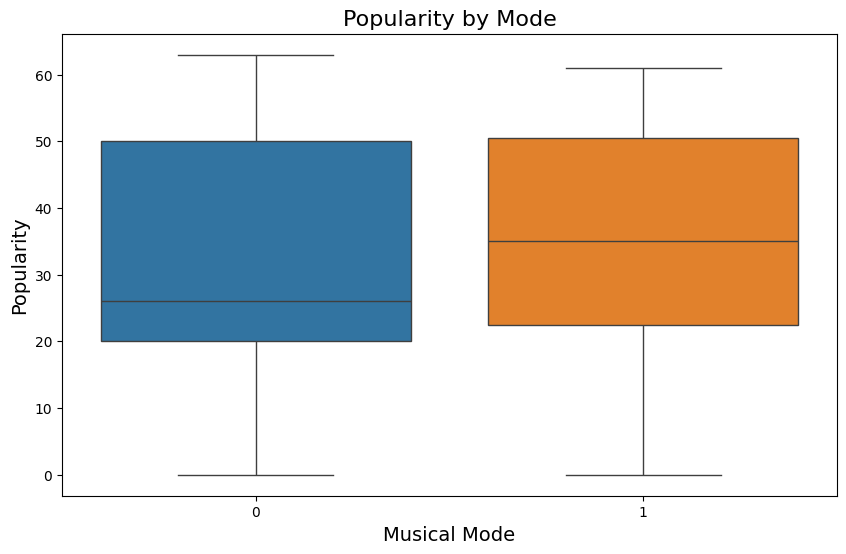

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define a list of colors for each mode
colors = ['#1f77b4', '#ff7f0e']  
# Create the boxplot with the specified colors and set 'hue' to 'Mode'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Mode', y='Popularity', data=data, hue='Mode', palette=colors, legend=False)

# Set the title and labels
plt.title('Popularity by Mode', fontsize=16)
plt.xlabel('Musical Mode', fontsize=14)
plt.ylabel('Popularity', fontsize=14)

# Display the plot
plt.show()


## Popularity vs Release Date

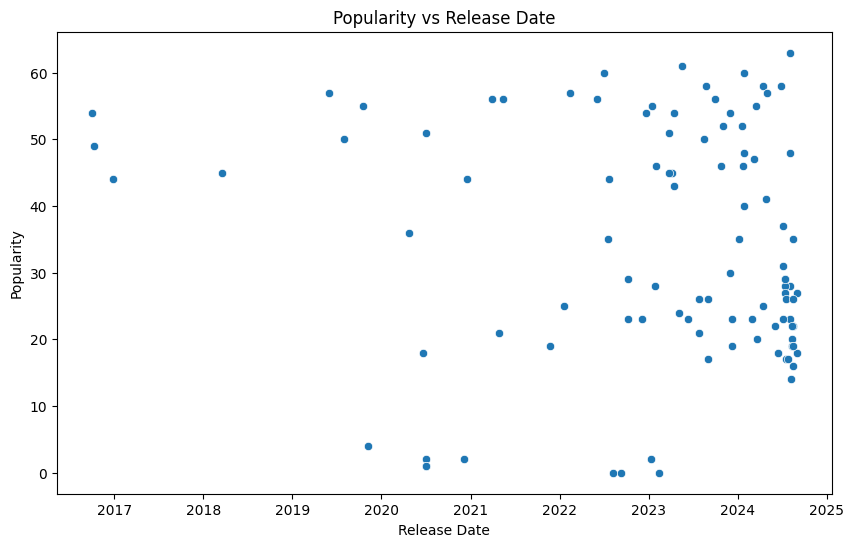

In [14]:
# Convert the 'Release Date' column to datetime format
music_df['Release Date'] = pd.to_datetime(music_df['Release Date'])

# Plot the popularity against release date
plt.figure(figsize=(10, 6))
sns.scatterplot(x=music_df['Release Date'], y=music_df['Popularity'])
plt.title('Popularity vs Release Date')
plt.xlabel('Release Date')
plt.ylabel('Popularity')
plt.show()

## Population Distribution

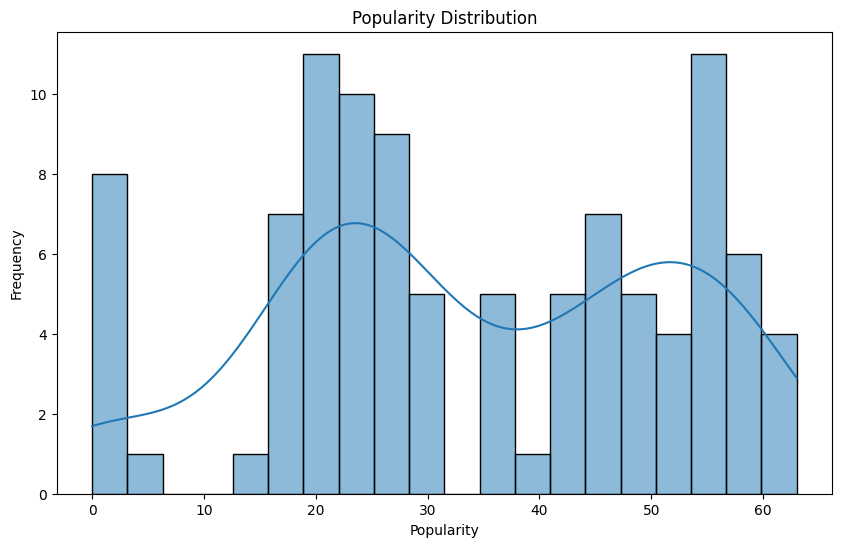

In [15]:
# Create a histogram of the popularity distribution
plt.figure(figsize=(10, 6))
sns.histplot(music_df['Popularity'], bins=20, kde=True)
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

## Correlation Heatmap

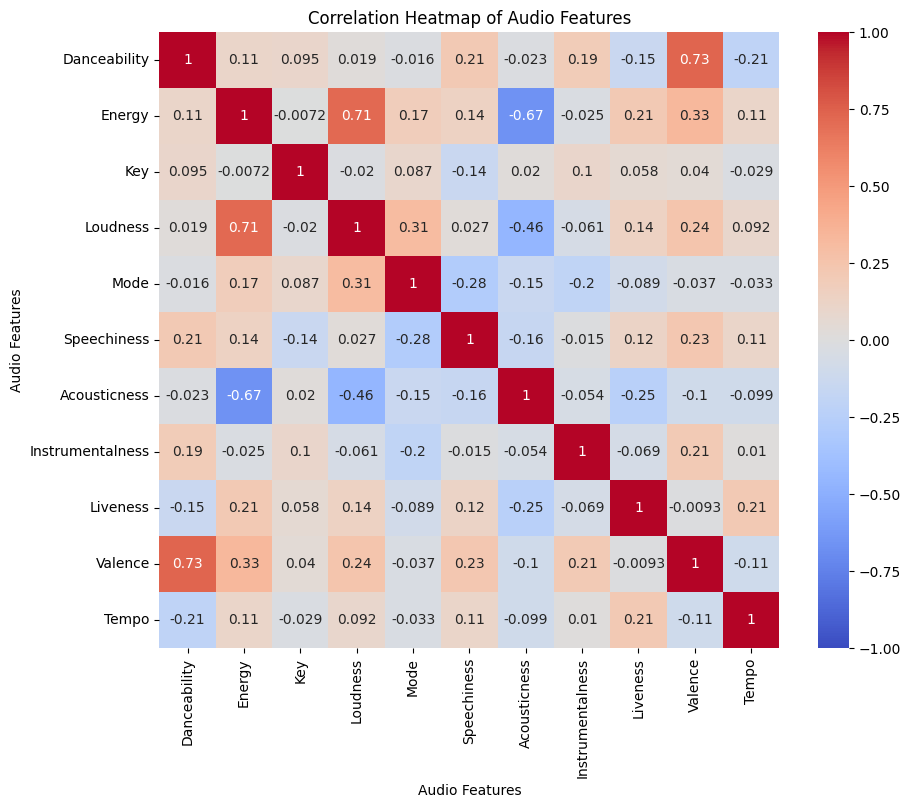

In [16]:
# Select the key audio features
audio_features = music_df[['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']]

# Calculate the correlation matrix
corr_matrix = audio_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Audio Features')
plt.xlabel('Audio Features')
plt.ylabel('Audio Features')
plt.show()

## Top 10 Artists

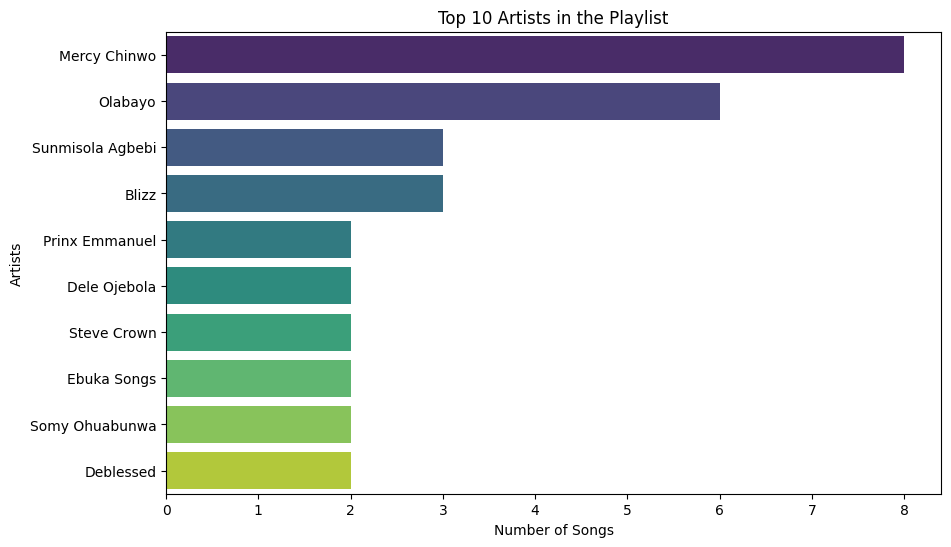

In [ ]:
# Count the number of songs by each artist
artist_counts = music_df['Artists'].value_counts()

# Get the top 10 artists
top_10_artists = artist_counts.head(10)

# Plot the top 10 artists
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_artists.values, y=top_10_artists.index, hue=top_10_artists.index, palette='viridis', dodge=False, legend=False)
plt.title('Top 10 Artists in the Playlist')
plt.xlabel('Number of Songs')
plt.ylabel('Artists')
plt.show()
